In this demo we'll learn how to implement a simple image captioning model! Credit for the code in this demo goes to https://github.com/yunjey/pytorch-tutorial

First we import some required libraries.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms 
import numpy as np 
import matplotlib.pyplot as plt
import pickle 
from PIL import Image

These next couple blocks are just some housekeeping we need to take care of (don't worry about these).

In [2]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


In [3]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    image = transforms.ToTensor()(image)
    image.requires_grad = True
    if transform is not None:
        image2 = transform(image)
        image2 = image2.unsqueeze(0)
    
    return image2, image

Now we can implement the encoder and decoder networks!

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [5]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

Finally, we are ready to test our implementation!

In [14]:
vocab_path = 'vocab/vocab.pkl'
encoder_path = 'pretrained_model/encoder-5-3000.pkl'
decoder_path = 'pretrained_model/decoder-5-3000.pkl'
image_path = 'example.png'

embed_size = 256
hidden_size = 512
num_layers = 1

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to C:\Users\brand/.torch\models\resnet152-b121ed2d.pth
241530880.0 bytes


<start> a group of giraffes standing next to each other . <end>


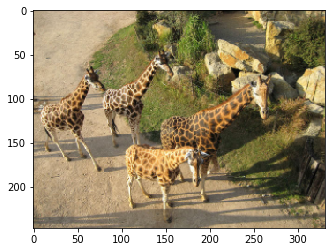

In [15]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder
decoder = decoder

# Load the trained model parameters
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

# Prepare an image
image, _ = load_image(image_path, transform)
image_tensor = image
nump = image_tensor.detach().numpy()
input_image = torch.tensor(nump, requires_grad=True)

# Generate an caption from the image
feature = encoder(input_image)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].numpy()          # (1, max_seq_length) -> (max_seq_length)

caption = torch.LongTensor([8397, 8601, 4694, 699, 2965, 511, 5282, 1496, 4966, 96]).unsqueeze(0)
output = decoder(feature, caption, [10])
loss = output.mean()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption
print (sentence)
image = Image.open(image_path)
plt.imshow(np.asarray(image))

Let's try to answer the question: what parts of the image most influence the output? Intelligent first guess: take the gradient of the loss wrt the input image!

In [16]:
loss.backward()

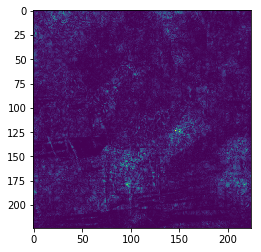

In [17]:
grad_sal = np.abs(input_image.grad.numpy()[0].transpose(1, 2, 0))
input_sal = np.abs(input_image.detach().numpy()[0].transpose(1, 2, 0))
plt.imshow((grad_sal * input_sal).max(axis=2))

This measure we derived is the notion of saliency, ie how much an image pixel contributes to the final output.